In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import random
import time
from network import *
from utility import *
from train import *
from config import *
import simpy
import logging

In [2]:
%matplotlib notebook
plt.ion()

In [3]:
env = simpy.Environment()

In [4]:
N = Network(STATIONS_FILENAME, RAILWAY_FILENAME , env)

In [5]:
def create_statistic_proc(env , logger , stat_time , N , trains):
    '''
    Create statistic in the log file every stat_time
    @parameters:
    env : simpy environment
    logger : log file where need to create the log
    stat_time : time after which log is to be created
    N         : network
    trains    : trains in the network
    '''
    global TRAINS_COMPLETED_JOURNEY
    while True :
        yield env.timeout(20)

        #create statistics
        not_yet_started = 0
        running = 0
        Completed_resource_not_freed = 0
        Completed = 0

        for t in trains:
            status = t.status()
            if (status == 'not_yet_started'):
                not_yet_started += 1
            elif (status == 'running'):
                running += 1
            elif(status == 'Completed_resource_not_freed'):
                Completed_resource_not_freed += 1
            else:
                Completed += 1
        
        if (len(trains) == Completed):
            TRAINS_COMPLETED_JOURNEY = True

        logger.info("Time : {} Number of trains not yet started - {}".format(env.now , not_yet_started))
        logger.info("Time : {} Number of running trains - {}".format(env.now , running))
        logger.info("Time : {} Number of trains Completed but resource not freed - {}".format(env.now , Completed_resource_not_freed))
        logger.info("Time : {} Number of trains which have Completed journey - {}".format(env.now , Completed))

In [6]:
#utility function
def update_graph (env , interval , train_to_color = None):
    '''
    This function will simulate the whole process on a GUI
    This function is going to be used as the process
    @parameters
    env : simpy environment
    total_time : total time for the simulation
    '''
    fig = plt.figure(figsize = (6 , 6))
    ax = fig.add_subplot(111)
    fig.show()
    fig.canvas.draw()
    
    while True:
        #Draw graph
        
        N.draw_railway_network(ax  = ax , suppress_station_info= False , 
                               suppress_track_info= False , suppress_edge_label=False , 
                               train_to_color=train_to_color)


        #yield interval time
        yield env.timeout(interval)
        time.sleep(1.0)
        
        #log info
        plt.title("Time {}".format(env.now))
        
        #Paint the canvas
        fig.canvas.draw()

In [7]:
def deadlock_detection_process (env , deadlock_time):
    '''
    For creating deadlock detection process
    '''
    global DEADLOCK
    while True:
        
        #Invoke this deadlock process after every 20 iterations
        
        yield env.timeout(deadlock_time)
        logger.info("Time : {} Checking Deadlock".format(env.now))
        DEADLOCK , _ = deadlock_detection(N , trains)
        


In [8]:
trains = read_trains(TRAINS_FILENAME , N , env)

In [9]:
name_train_map = {}                #Map from train name to train object; note key can be changed to train_id 
for t in trains:
    name_train_map[t.name] = t

In [10]:
#Define a map from train to color to which it belongs 
#Note this feature considers only 10 trains into account
colors = ['red' , 'saddlebrown' , 'forestgreen' , 'darkcyan' , 'royalblue' , 'magenta' , 'darkorange' ,
          'dimgray'] 
permanent_color = 'lightcoral'

train_to_color = {}
if (len(trains) <= 8):
    for i,t in enumerate(trains):
        train_to_color[t.name] = colors[i]
else:
    for i,t in enumerate(trains):
        train_to_color[t.name] = permanent_color
        
print(train_to_color)


{'Train001': 'red', 'Train002': 'saddlebrown', 'Train003': 'forestgreen', 'Train004': 'darkcyan', 'Train011': 'royalblue', 'Train012': 'magenta', 'Train013': 'darkorange', 'Train014': 'dimgray'}


In [11]:
logger = setup_logger("main_log_file" ,"Logs/log.log")

In [12]:
sim_proc = env.process(update_graph(env , 1 , train_to_color = train_to_color))
dead_proc = env.process(deadlock_detection_process(env , 20))
stat_proc = env.process(create_statistic_proc(env , logger , 20 , N , trains))

for t in trains:
    proc = env.process(t.put_train_on_track(env))
    
proc_act = env.process(choose_action(env , N, name_train_map))

<IPython.core.display.Javascript object>


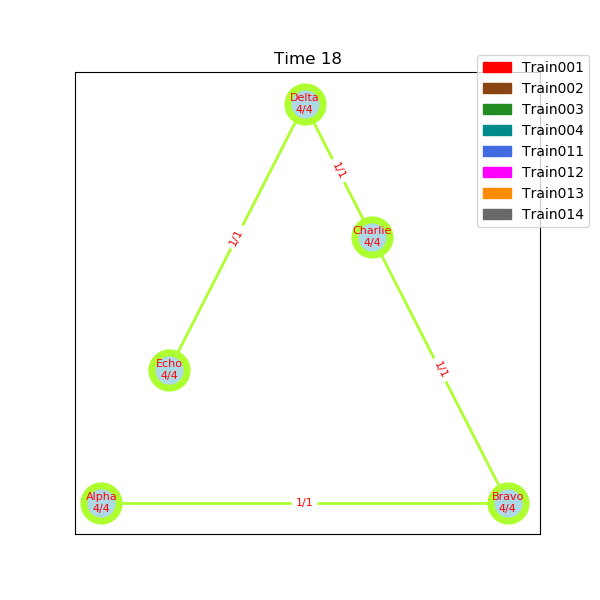

In [ ]:
for _ in range(TOTAL_SIMULATION_TIME):
    
    if (DEADLOCK== False):
        logger.warning("Time : {} Terminating Simulation. Deadlock detected".format(env.now))
        print("Terminating Simulation : Deadlock detected")
        break
        
    if (TRAINS_COMPLETED_JOURNEY == True):
        logger.info("Time : {} All trains completed journey. Terminating Simulation".format(env.now))
        print("Terminating Simulation : All trains completed journey")
        break
    
    CURRENT_SIMULATION_TIME += 1
    
    
    #Run the simulation
    env.run(until = CURRENT_SIMULATION_TIME)
    

In [ ]:
G,train_nodes , station_nodes , track_nodes = create_resource_usage_graph(trains , N)

In [ ]:
fig = plt.figure(figsize = (6 , 6))
ax = fig.add_subplot(111)
draw_network_usage_graph(G,train_nodes , station_nodes , track_nodes, N,ax)

In [ ]:
# TODO
'''
1. Create a simple train class with all the parameters                                                Done
2. Implement the resource facility with the track and the station                                     Done
3. Run the single train on the track (without getting worried wether the resource is free or not)     Done  
4. Simulate whole thing on graph (single train only)                                                  Done
5. Run multiple instances of the train without worrying about the deadlock                            Done
   Create action for each train                                                                       Done
6. Try to simulate as you want to do in the project i.e. take action from the user.                   Done
   Also able to order the train for which to take the action at a particular time 
   
   
   
7. Try to create deadlock with the trains                                                             Done 
8. Create the graph for resource usage.                                                               Done  
9. Use the standard deadlock detection algorithm for the detection of the algorithm                   Done 
   Implement the Bank's algorithm for deadlock detection.
'''

In [ ]:
'''
List of reasons of creating events
1. If a train is standing at a station, the event processing time            Can be done by implementing timeout if train arrive early before depart time
    corresponds to the earliest time at which the train can depart,          occupancy of next track.
    as defined by its minimum halt time at the station and by any           Done
    departure time constraints enforced for passenger convenience.

2. `If it is running between two stations, the event processing time         Already done   
    corresponds to the earliest time at which it can arrive at the          occupancy of next station if move.
    next station, as defined by the length of the track and the train       Done
    running speed.

3. If the train is yet to start, the event processing                       Done
    time is the time at which it is expected at the starting station.       
'''

In [ ]:
#TODO
'''
Create the actions properly and implement deadlock Avoidance heuristic

1. Code the proper list of events. All the three listed above.                                      Done
2. Create the proper time table with arrival and departure time of each train at each station.      Done
3. Create separate log file for each train.                                                         Done
3. Run simulation with the first toy environment (as in the paper).                                 Done
4. Label the current set of implementation under Simulation Phase.                                  Done
5. Implement the actions properly without actually waiting for the resource.                        Done
6. Understand Heuristic that can be used to avoid deadlock.                                         Done
7. Move that train that occupies the most congested resource first and then other.                  Done
   If tie break it using priority of each train.
   
   
8. Implement the state vector when action need to be taken.                                       Note Done

'''

In [ ]:
avail = np.array([0,0,0])  
  
# Maximum R that can be allocated  
# to processes  
maxm = np.array([[0, 1, 0], [4, 0, 2], 
        [3, 0, 4], [3, 1, 1], 
        [0, 0, 4]]) 

# Resources allocated to processes  
allot = np.array([[0, 1, 0], [2, 0, 0], 
         [3, 0, 3], [2, 1, 1], 
         [0, 0, 2]])  

# Check system is in safe state or not  
isSafe(avail, maxm, allot)  

In [ ]:
deadlock_detection (N , trains)

In [ ]:
def choose_action_one_train (env, train):
    '''
    After each unit time: this function will check if the train need the action or not
    If yes : this will take the action for the train and check again if it needs action
    This keeps on happening
    '''
    
    global TRAINS_NEEDING_ACTION
    actions = ['move' , 'wait']
    while True:
        
        #keep on taking the action for the train till it is not present in TRAINS_NEEDING_ACTION
        while (train.name in TRAINS_NEEDING_ACTION):
            action = np.random.choice(actions , 1 , p = [1 , 0])

            #Take the action
            yield env.process(t.act(env , action))

            #remove the train from the list
            TRAINS_NEEDING_ACTION.remove(train.name)
        
        yield env.timeout(1)
        

In [ ]:
def choose_action_temp (env):
    #Process the action for the trains in the list    
    #randomly take action for each train waiting for action 
    #We can also order the train for which we are taking the action depending on the situation
    global TRAINS_NEEDING_ACTION
    actions = ['move' , 'wait']
    
    temp_trains_needing_action = TRAINS_NEEDING_ACTION
    
    for name in temp_trains_needing_action:
        t = name_train_map[name]
        
        action = np.random.choice(actions , 1 , p = [1 , 0])          #move with 50% probability
        
        #Take the action
        yield env.process(t.act(env , action))
        
        #remove the train from the list
        TRAINS_NEEDING_ACTION.remove(name)
        
        

In [ ]:
def choose_action_process(env):
    #Choose action
    while True:
        while (not len(TRAINS_NEEDING_ACTION) == 0 ):
            yield env.process(choose_action(env))
    
        yield env.timeout(1)